In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import torch

In [42]:
avg_label_vector=[1.74596621e-01, 3.70247139e-02, 4.33084123e-02, 6.24962418e-03, 8.01747810e-06, 
                  4.66416789e-03, 2.08654868e-03, 6.59437574e-04, 4.00873905e-05, 7.31362370e-01]


In [43]:
avg_label_vector=[1.74596621e-01, 3.70247139e-02, 4.33084123e-02, 6.24962418e-03,  
                  4.66416789e-03, 2.08654868e-03, 6.59437574e-04, 7.31362370e-01]

class_weights_tensor = torch.FloatTensor(avg_label_vector)

# create weight tensor from frenquency  of each class
class_weights_tensor = torch.FloatTensor(avg_label_vector)
class_weights_tensor = 1/class_weights_tensor
class_weights_tensor = class_weights_tensor/class_weights_tensor.sum()

In [44]:
class_weights_tensor

tensor([2.3596e-03, 1.1127e-02, 9.5127e-03, 6.5921e-02, 8.8329e-02, 1.9745e-01,
        6.2474e-01, 5.6330e-04])

In [45]:
custom_weight = torch.Tensor([2.3596e-03, 1.1127e-02, 9.5127e-03, 6.5921e-02, 2e-02, 8.8329e-02, 1.9745e-01,
        6.2474e-01, 2e-2, 5.6330e-04])

In [46]:
#normalize the weights

custom_weight = custom_weight/custom_weight.sum()

In [47]:
custom_weight

tensor([2.2688e-03, 1.0699e-02, 9.1468e-03, 6.3385e-02, 1.9231e-02, 8.4932e-02,
        1.8986e-01, 6.0071e-01, 1.9231e-02, 5.4163e-04])

In [48]:
# apply a softmax to the class weights

import torch.nn.functional as F
class_weights_tensor = F.softmax(class_weights_tensor, dim=0)

In [49]:
class_weights_tensor

tensor([0.1081, 0.1091, 0.1089, 0.1152, 0.1178, 0.1314, 0.2015, 0.1079])

In [1]:
from pathlib import Path

In [2]:

import sys
import os
cwd = os.getcwd()
parent_dir = os.path.dirname(cwd)
sys.path.append(parent_dir)
from DataPipeline.dataset import ZincSubgraphDataset, custom_collate
from DataPipeline.preprocessing import plot_graph

from torch_geometric.utils import to_networkx
import torch

In [3]:
def torch_geometric_to_networkx(data):
    """
    Convert a torch_geometric.data.Data object into a networkx.Graph object.

    Args:
    data (torch_geometric.data.Data): A PyTorch Geometric Data object representing the molecule.

    Returns:
    G (networkx.Graph): A NetworkX Graph object representing the molecule.
    """
    # Modify node features to take the argmax, excluding the last element
    if data.x.shape[1] > 1:
        data.x = torch.argmax(data.x[:, :-1], dim=1).unsqueeze(1)

    # Modify edge features to take the argmax
    if data.edge_attr.shape[1] > 1:
        data.edge_attr = torch.argmax(data.edge_attr, dim=1).unsqueeze(1)

    G = to_networkx(data, node_attrs=['x'], edge_attrs=['edge_attr'])

    for i in G.nodes:
        x_attr = G.nodes[i]['x']
        atomic_num = int(x_attr.item()) if hasattr(x_attr, 'item') else int(x_attr)
        G.nodes[i]['atomic_num'] = atomic_num
        del G.nodes[i]['x']

    for i, j in G.edges:
        edge_attr = G.edges[i, j]['edge_attr']
        bond_type = edge_attr.item() if hasattr(edge_attr, 'item') else edge_attr
        G.edges[i, j]['bond_type'] = bond_type
        del G.edges[i, j]['edge_attr']

    return G

In [4]:
from torch.utils.data import DataLoader

from torch_geometric.data import Batch

In [5]:
datapath = Path('..') / 'DataPipeline/data/preprocessed_graph_no_I_Br_P.pt'
dataset = ZincSubgraphDataset(data_path = datapath)

Dataset encoded with size 7


In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0, collate_fn=custom_collate)

In [7]:
import networkx as nx

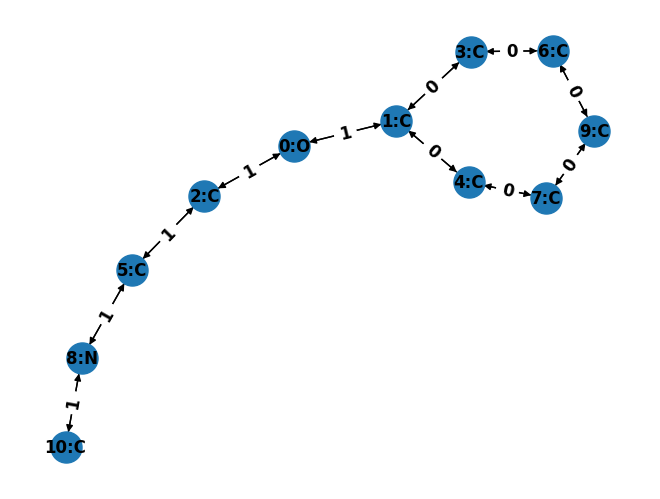

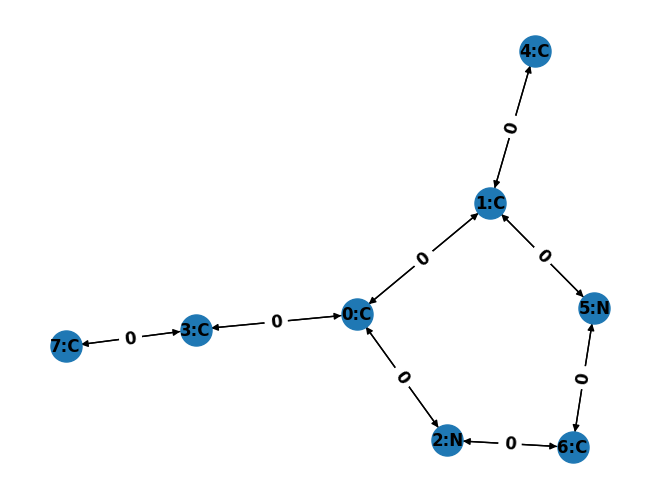

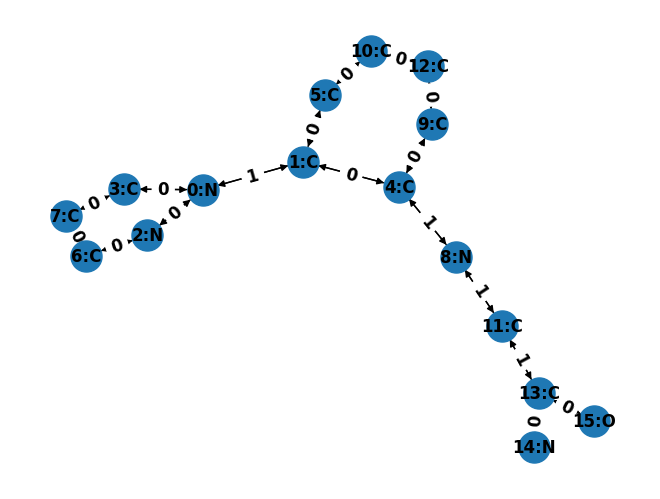

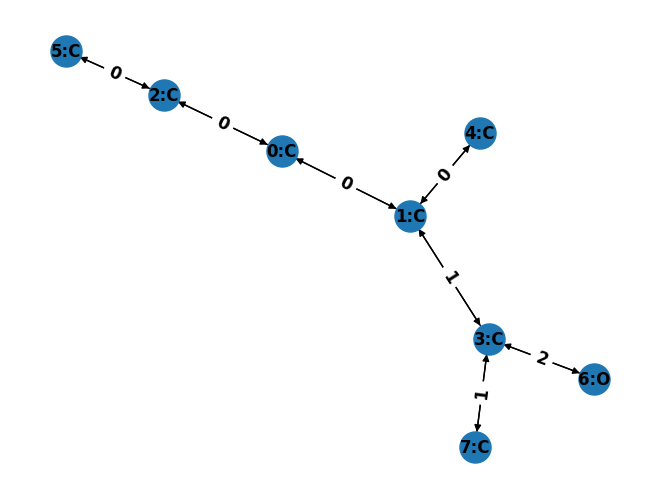

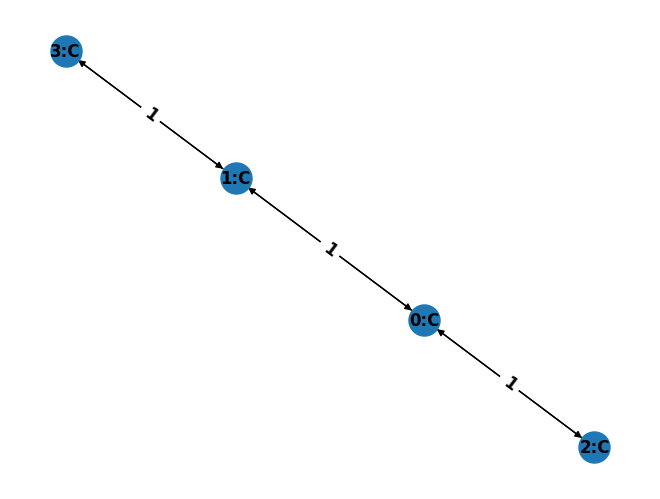

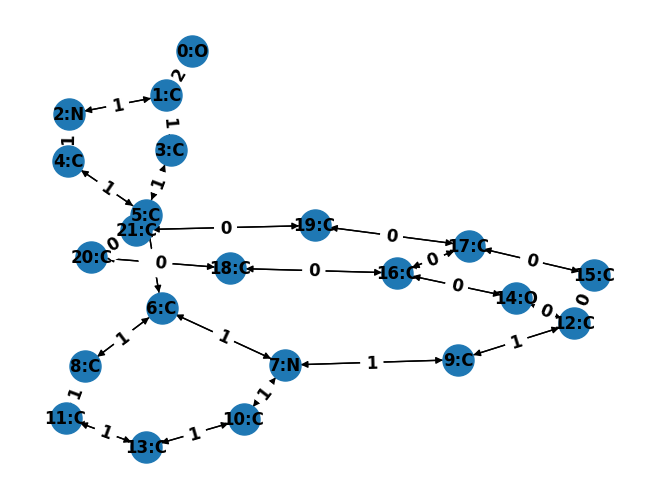

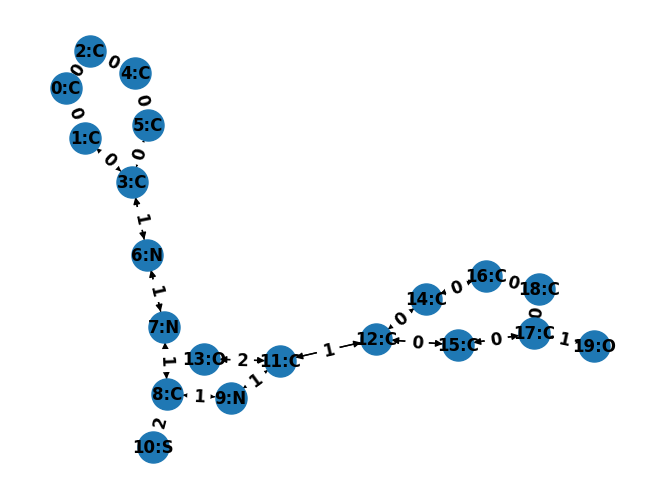

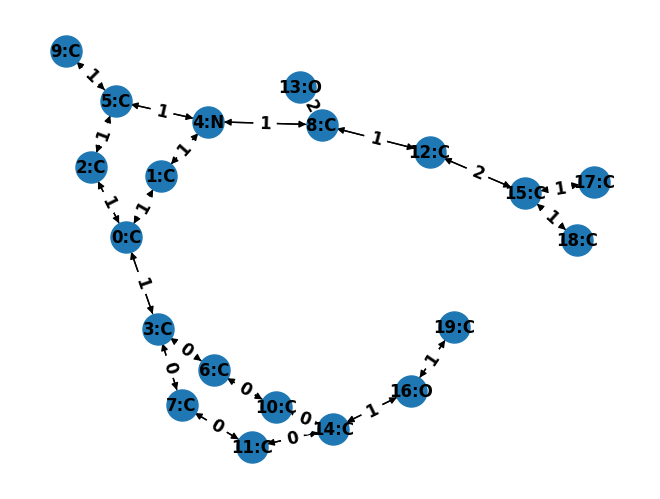

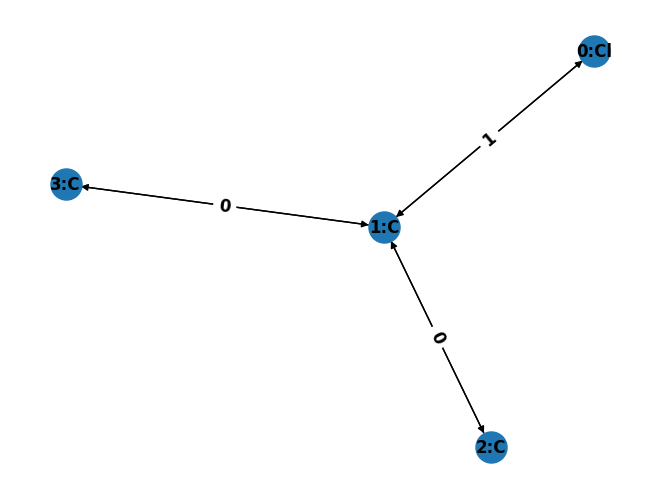

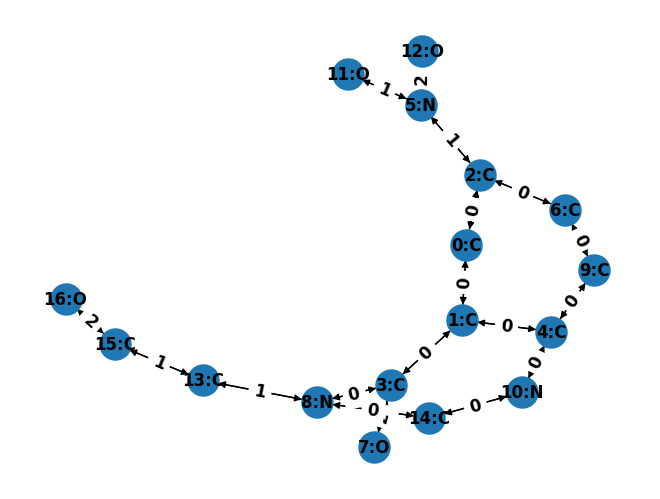

In [8]:
i = 0

for batch in dataloader:
    i += 1
    data_list = Batch.to_data_list(batch[0])
    network_graph = torch_geometric_to_networkx(data_list[0])

    plot_graph(network_graph, atom_conversion_type='onehot', encoding_type='reduced')

    if i == 10:
        break